# New York City Taxi Fare Prediction Playground Competition 

In [1]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm

nytaxi_data_dir='/mnt/c/Users/hkver/Documents/dbai/nytaxidata/'
os.listdir(nytaxi_data_dir)

['GCP-Coupons-Instructions.rtf',
 'new-york-city-taxi-fare-prediction.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

## Data cleaning & Feature engineering

In [2]:
def remove_outliers(df):
    df = df.dropna()
    mask = df['fare_amount'].between(0, 500)
    mask &= df['passenger_count'].between(0, 6)

    # to select coordinates: https://www.openstreetmap.org/export
    mask &= df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)

    return df[mask]

def manhattan(pickup, dropoff):
    pickup_long, pickup_lat = pickup
    dropoff_long, dropoff_lat = dropoff
    return np.abs(dropoff_long - pickup_long) + np.abs(dropoff_lat - pickup_lat)

def extract_distance_features(df):
    df['abs_diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    df['abs_diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()

    pickup = (df['pickup_longitude'], df['pickup_latitude'])
    dropoff = (df['dropoff_longitude'], df['dropoff_latitude'])
    df['distance'] = manhattan(pickup, dropoff)

    # Distances to nearby airports, and city center
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    coordinates = {
        'nyc': (-74.0063889, 40.7141667),
        'jfk': (-73.7822222222, 40.6441666667),
        'ewr': (-74.175, 40.69),
        'lgr': (-73.87, 40.77)
    }

    for name, coord in coordinates.items():
        df[f'pickup_distance_to_{name}'] = manhattan(coord, pickup)
        df[f'dropoff_distance_to_{name}'] = manhattan(coord, dropoff)

    return df

def extract_datetime_features(df):
    # Removing unecessary information from the datetime string
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    pickup_datetime = df['pickup_datetime'].str.slice(0, 16)
    pickup_datetime = pd.to_datetime(pickup_datetime, utc=True, format='%Y-%m-%d %H:%M')

    df['year'] = pickup_datetime.dt.year
    df['month'] = pickup_datetime.dt.month
    df['day'] = pickup_datetime.dt.day
    df['dayofweek'] = pickup_datetime.dt.dayofweek
    df['hour'] = pickup_datetime.dt.hour

    return df.drop(columns='pickup_datetime')

def extract_features(df):
    df = extract_distance_features(df)
    df = extract_datetime_features(df)
    return df

## Setup data

In [3]:
# save some space from the defaults float64 and int64
dtypes = {'fare_amount': 'float32',
          'pickup_datetime': 'str',
          'pickup_longitude': 'float32',
          'pickup_latitude': 'float32',
          'dropoff_longitude': 'float32',
          'dropoff_latitude': 'float32',
          'passenger_count': 'uint8'}

val_size = 10_000
input_path = nytaxi_data_dir+'train.csv'

val_df = pd.read_csv(input_path, usecols=dtypes.keys(), dtype=dtypes, nrows=val_size)
val_df = remove_outliers(val_df)
val_df = extract_features(val_df)

X_val = val_df.drop(columns='fare_amount')
y_val = val_df[['fare_amount']]
dval = xgb.DMatrix(X_val, y_val, feature_names=X_val.columns)

batch_size = 10_000_000
columns = pd.read_csv(input_path, nrows=0).columns
train_df = pd.read_csv(input_path, usecols=dtypes.keys(), dtype=dtypes,
                       names=columns, skiprows=val_size + 1,
                       chunksize=batch_size)
val_df.dtypes

fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count              uint8
abs_diff_longitude         float32
abs_diff_latitude          float32
distance                   float32
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
year                         int64
month                        int64
day                          int64
dayofweek                    int64
hour                         int64
dtype: object

## Training

In [4]:
params = {'learning_rate': 0.05,
          'max_depth': 7,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'subsample': 0.8,
          'gamma': 1,
          'silent': True,
          'verbose_eval': True}

num_rounds = 16
model = None
for batch_df in tqdm(train_df):
    batch_df = remove_outliers(batch_df)
    batch_df = extract_features(batch_df)

    X_train = batch_df.drop(columns='fare_amount')
    y_train = batch_df[['fare_amount']]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)

    model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=5,
                      evals=[(dtrain, 'train'), (dval, 'eval')],
                      xgb_model=model)

0it [00:00, ?it/s]

[17:18:59] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:18:59] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:13.86330	eval-rmse:13.69100
[1]	train-rmse:13.23507	eval-rmse:13.07215
[2]	train-rmse:12.64602	eval-rmse:12.48704
[3]	train-rmse:12.08657	eval-rmse:11.93444
[4]	train-rmse:11.55992	eval-rmse:11.41128
[5]	train-rmse:11.06140	eval-rmse:10.91780
[6]	train-rmse:10.59513	eval-rmse:10.45217
[7]	train-rmse:10.15013	eval-rmse:10.01428
[8]	train-rmse:9.73426	eval-rmse:9.60218
[9]	train-rmse:9.34135	eval-rmse:9.21295
[10]	train-rmse

1it [09:25, 565.54s/it]

[17:28:49] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.18450	eval-rmse:7.08589
[1]	train-rmse:6.94827	eval-rmse:6.85275
[2]	train-rmse:6.72806	eval-rmse:6.63648
[3]	train-rmse:6.52071	eval-rmse:6.43427
[4]	train-rmse:6.32751	eval-rmse:6.24225
[5]	train-rmse:6.14836	eval-rmse:6.06470
[6]	train-rmse:5.98248	eval-rmse:5.90510
[7]	train-rmse:5.82657	eval-rmse:5.75593
[8]	train-rmse:5.68381	eval-rmse:5.61770
[9]	train-rmse:5.54846	eval-rmse:5.48442
[10]	train-rmse:5.42399	eval-rmse:5.36537
[11]	train-rmse:5.30838	eval-rmse:5.25590
[12]	train-rmse:5.20126	eval-rmse:5.15616
[13]	train-rmse:5.10155	eval-rmse:5.06404
[14]	train-rmse:5.00923	eval-rms

2it [18:54, 567.35s/it]

[17:38:01] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.82888	eval-rmse:4.82780
[1]	train-rmse:4.75619	eval-rmse:4.75961
[2]	train-rmse:4.68923	eval-rmse:4.69683
[3]	train-rmse:4.62716	eval-rmse:4.63891
[4]	train-rmse:4.57069	eval-rmse:4.58791
[5]	train-rmse:4.51745	eval-rmse:4.53722
[6]	train-rmse:4.46857	eval-rmse:4.49031
[7]	train-rmse:4.42335	eval-rmse:4.44894
[8]	train-rmse:4.38301	eval-rmse:4.41393
[9]	train-rmse:4.34336	eval-rmse:4.37358
[10]	train-rmse:4.30842	eval-rmse:4.34308
[11]	train-rmse:4.27503	eval-rmse:4.31595
[12]	train-rmse:4.24518	eval-rmse:4.28944
[13]	train-rmse:4.21781	eval-rmse:4.26054
[14]	train-rmse:4.19215	eval-rms

3it [28:50, 580.68s/it]

[17:48:14] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.15679	eval-rmse:4.20359
[1]	train-rmse:4.13540	eval-rmse:4.18669
[2]	train-rmse:4.11628	eval-rmse:4.17048
[3]	train-rmse:4.09932	eval-rmse:4.15046
[4]	train-rmse:4.08276	eval-rmse:4.13920
[5]	train-rmse:4.06792	eval-rmse:4.12333
[6]	train-rmse:4.05276	eval-rmse:4.11624
[7]	train-rmse:4.04017	eval-rmse:4.10535
[8]	train-rmse:4.02745	eval-rmse:4.09602
[9]	train-rmse:4.01661	eval-rmse:4.08246
[10]	train-rmse:4.00470	eval-rmse:4.07247
[11]	train-rmse:3.99462	eval-rmse:4.06344
[12]	train-rmse:3.98613	eval-rmse:4.05660
[13]	train-rmse:3.97653	eval-rmse:4.05151
[14]	train-rmse:3.96840	eval-rms

4it [39:22, 601.01s/it]

[17:59:04] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.93477	eval-rmse:4.03824
[1]	train-rmse:3.92858	eval-rmse:4.03531
[2]	train-rmse:3.92241	eval-rmse:4.02662
[3]	train-rmse:3.91622	eval-rmse:4.02446
[4]	train-rmse:3.91071	eval-rmse:4.02244
[5]	train-rmse:3.90430	eval-rmse:4.01709
[6]	train-rmse:3.89996	eval-rmse:4.01340
[7]	train-rmse:3.89512	eval-rmse:4.01257
[8]	train-rmse:3.89089	eval-rmse:4.01160
[9]	train-rmse:3.88706	eval-rmse:4.00892
[10]	train-rmse:3.88039	eval-rmse:4.00208
[11]	train-rmse:3.87690	eval-rmse:3.99972
[12]	train-rmse:3.87306	eval-rmse:4.00098
[13]	train-rmse:3.86785	eval-rmse:3.99540
[14]	train-rmse:3.86446	eval-rms

5it [3:01:12, 3452.84s/it]

[20:20:09] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:3.87116	eval-rmse:3.98818
[1]	train-rmse:3.86657	eval-rmse:3.98725
[2]	train-rmse:3.86381	eval-rmse:3.98672
[3]	train-rmse:3.86019	eval-rmse:3.98462
[4]	train-rmse:3.85790	eval-rmse:3.98554
[5]	train-rmse:3.85488	eval-rmse:3.98379
[6]	train-rmse:3.85182	eval-rmse:3.98479
[7]	train-rmse:3.84971	eval-rmse:3.98342
[8]	train-rmse:3.84690	eval-rmse:3.98159
[9]	train-rmse:3.84418	eval-rmse:3.98040
[10]	train-rmse:3.84172	eval-rmse:3.97839
[11]	train-rmse:3.83845	eval-rmse:3.97571
[12]	train-rmse:3.83665	eval-rmse:3.97437
[13]	train-rmse:3.83429	eval-rmse:3.97266
[14]	train-rmse:3.83188	eval-rms

6it [3:06:50, 1868.36s/it]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

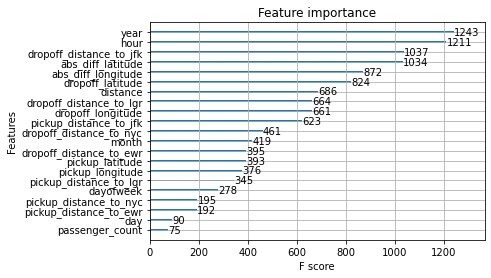

In [6]:
xgb.plot_importance(model)

## Predictions

In [7]:
test_df = pd.read_csv(nytaxi_data_dir+'test.csv')
test_df = extract_features(test_df)
test_df.dtypes

key                         object
pickup_longitude           float64
pickup_latitude            float64
dropoff_longitude          float64
dropoff_latitude           float64
passenger_count              int64
abs_diff_longitude         float64
abs_diff_latitude          float64
distance                   float64
pickup_distance_to_nyc     float64
dropoff_distance_to_nyc    float64
pickup_distance_to_jfk     float64
dropoff_distance_to_jfk    float64
pickup_distance_to_ewr     float64
dropoff_distance_to_ewr    float64
pickup_distance_to_lgr     float64
dropoff_distance_to_lgr    float64
year                         int64
month                        int64
day                          int64
dayofweek                    int64
hour                         int64
dtype: object

In [8]:
X_test = test_df.drop(columns='key')
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)
y_pred = model.predict(dtest)

submission = pd.DataFrame({'key': test_df['key'], 'fare_amount': y_pred})
submission.to_csv('submission.csv', index = False)

!head submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,10.420856
2015-01-27 13:08:24.0000003,10.272775
2011-10-08 11:53:44.0000002,4.869689
2012-12-01 21:12:12.0000002,7.865706
2012-12-01 21:12:12.0000003,15.024224
2012-12-01 21:12:12.0000005,10.558723
2011-10-06 12:10:20.0000001,5.115378
2011-10-06 12:10:20.0000003,48.989258
2011-10-06 12:10:20.0000002,10.905418
